In [3]:
"""
This project is an implementation of SIFT(Scale Invariant Feature Transform, including feature point detection and description), 
which extracts distinctive invariant features from images that can be used to perform reliable matching between different views 
of an object or scene.Following are the major stages of generating the set of image features(a division of stages in my code is 
slightly different from Lowe's paper):
    
1.The first stage is to generate a Difference-of-Gaussian Pyramid. The difference-of-Gaussian function provides a close approxi-
mation to the scale-normalized Laplacian of Gaussian whose maxima and minima produce the most stable image features. In this 
stage, we generate the gaussian Pyramid first, then we can get the DoG by repeating the subtraction of two adjacent image scales
in the same octave.

2.After getting the DoG Pyramid, the next step is the local scale-space extrema detection and key point localization. Maxima and
minima of the DoG images are detected by comparing a pixel to its 26 neighbors in 3×3 regions at the current and adjacent scales.
Once a key point candidate has been found by comparing a pixel to its neighbors, what we need to do is fitting these discrete 
points to accurately localize the position and scale of the key point, which also means the determination of the interpolated 
location is needed(using Taylor expansion (up to the quadratic terms) of the scale-space function). The interpolation also pro-
vides a substantial improvement to matching and stability. We also need to check the contrast value and curvature value to remove
some undesired points. The low contrast point needed to be removed since they have very low intensity which means they are very 
sensitive to noise as well. In addition, the edge-like points should be removed too as the DoG images has a strong response to 
image edge points which means they are easy to be unstable influenced by noise. The last step in this stage is recording the 
information that we need of all key points in the next stage.

3.The third stage is orientation assignment. So far, we have achieved the scale invariance by the above stages. The rotation in-
variance can be achieve by assigning a consistent orientation to each key point based on local image properties. For every key 
point, we need to compute the gradient and weight it to assign a direction to it, which is based on a weighted direction histo-
gram in its neighborhood. To be specific, the first step of this stage is to determine some parameters. Considering the key point
as center, We calculate the gradient of all the pixels within the gaussian-weighted circular window whose radius is 3*1.5*σ where
σ is the accurate scale of the key point. All the gradient magnitude within the circular window have different contribution to 
the center, and that's why we need to weight all of them using gaussian filter whose variance is 1.5*σ. After the preparing step,
we start computing the histogram based on the direction. Given a gradient direction, Divide 360° to 36 bins and put the corre-
sponding weighted magnitude into the bins. Hence the histogram is built. In order to prevent the case that a certain gradient 
direction suddenly change due to the noise, a smoothing process is required. Then we are able to select the highest peak value of 
the histogram. If the local peak is at least 80% of the highest peak, we treat its corresponding direction bin as the main direc-
tion of the key point and use a feature to record the accurate loaction and scale. The bin number may not be the exactly max value,so a parabola interpolation is needed to fit the discrete 
direction histogram to obtain the accurate bin number. Finally, the direction where this accurate bin belongs to is 
gotten, which is the orientation we want to assign to the key point.

4.Since above invariance properties is obtained, the last stage of SIFT is generating a descriptor for the local image area that
is highly distinctive yet is as invariant as possible to remaining variations, such as change in illumination or 3D viewpoint. A
SIFT descriptor is a 4*4*8=128 bins histogram sampling in the neighborhood of a feature point. Generating a SIFT has the follow-
ing major steps: The first step of is to define a sampling region. In a gaussian image, the neighborhood to be sampled is divided
into 4x4 regions. There are also 8 bins in gradient direction hence we get the 128 bins in total. The second step is rotating the
coordinates of the descriptor and the gradient orientations relative to the key point orientation to achieve orientation invari-
ance. After previous rotation, we can compute the histogram using a Gaussian weighting function to avoid sudden changes in the 
descriptor with small changes in the position of the window, and to give less emphasis to gradients that are far from the center
of the descriptor. The last step is using tri-linear interpolation to distribute the value of each gradient sample into adjacent
histogram bins for the purpose of avoiding all boundary affects in which the descriptor abruptly changes as a sample shifts 
smoothly from being within one histogram to another or from one orientation to another. To have illumination variations, Normali-
zing the histogram is needed to get rid of the influence introduced by illumination change. Also, a threshold is needed to miti-
gate the influence introduced by this non-linear illumination change since Non-linear change of illumination still exists. To 
make these key points distinctive, we need to normalize the feature vector again.

So far, a SIFT algorithm is completed. Following is the code with detailed comments.
   
Reference paper: Distinctive Image Features from Scale-Invariant Keypoints, DAVID G. LOWE.

@Project author:Yushan Jiang
"""

import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
from skimage import img_as_float

def calc_grad(I,x,y):#A function to calculate the magnitude and phase of gradient, given a pixel within the image
    grad=np.zeros(3)
    h=I.shape[0]
    w=I.shape[1]
    if x>0 and x<w-1 and y>0 and y<h-1:#Here we simply ignore the boundary pixels 
        dx=I[y,x+1]-I[y,x-1]
        dy=I[y+1,x]-I[y-1,x]
        grad[0]=np.sqrt(dx*dx+dy*dy)#Calculate the magnitiude
        grad[1]=math.atan2(dy,dx)#Calculate the phase
        grad[2]=0#grad[2] is a flag to show whether the pixel is in the border or not
    else:
        grad[2]=1
    return grad
        
        

def kernel_size(sig):#A function to calculate the kernel size for gaussian blur 
    k=np.round(6*sig+1)#3σ principle
    if np.mod(k,2)==0:#The kernel size should be a odd number
        k=k+1
    return int(k)
def sift(A1):
    A=img_as_float(A1)#Gray image normalization
    h = A.shape[0]  #Height of IMAGE
    w = A.shape[1]  #Width of IMAGE
    S=3# Intervals(scales) per octave,3 is choosen in Lowe's paper
    
    k=np.power(2,1/S)#Divide each octave of scale space (i.e., doubling of σ) into an integer number of intervals
    sigma0=1.6#Initial sigma
    sigma_pre=np.sqrt(sigma0*sigma0-(2*0.5)*(2*0.5))#Assume that the original image has a blur of at least σ = 0.5, additional σ is needed to prior to creation of the first octave of scale space 
    sigma =np.zeros(S+3)#Store all the σ values for different intervals in the same octave
    sigma[0]=sigma0#Initial sigma
    
    # Generate Gaussian pyramid for A
    A_pre=cv2.resize(A,(w*2, h*2))#Previously enlarge the original image by a factor of 2 in order to have more feature points(increases the number of stable keypoints by almost a factor of 4.)
    #ATTENTATION:One difference between cv2.resize function and other resize funtions is that we should put the width as the first parameter instead of height.
    img = cv2.GaussianBlur(A_pre,(kernel_size(sigma_pre),kernel_size(sigma_pre)) ,sigma_pre)#The only possible scale-space kernel is the Gaussian function(Koenderink, 1984; Lindeberg, 1994）.
    o =int(np.log2(min(img.shape[0],img.shape[1])))-2 #The number of octaves
    for i in range(1,S+3):
        sig_prev=sigma[0]*np.power(k,i-1)
        sig_total=sig_prev*k
        sigma[i]=np.sqrt(sig_total*sig_total-sig_prev*sig_prev)#We process gaussian blur for the previous image instead of processing the first image for many times, which means what we need is the relative σ in the same octacve rather than the overall σ for the entire pyramid.
    
        
    #Creat space for gaussian pyramid    
    gpA=np.empty((o,S+3),dtype=object)
    
    #Generate Gaussian Pyramid        
    for i in range(o):
        for j in range(S+3):
            if i==0 and j==0:#The first image in the first octave of gaussian images
                gpA[i,j]=img
            elif j==0:#j=0 means the process gets into the next octave,which means the width and height of images need to be half as the previous octave ones
                gpA[i,j]=cv2.resize(gpA[i-1,S],(int(gpA[i-1,S].shape[1]*0.5), int(gpA[i-1,S].shape[0]*0.5)))#The σ of current image is the same as the third to last image in the previous octave
            else:# j!=0 means that we process the image in the same octave 
                gpA[i,j]=cv2.GaussianBlur(gpA[i,j-1],(kernel_size(sigma[j]),kernel_size(sigma[j])) ,sigma[j])# a gaussian blur for the previous interval image using the relative σ
    # Generate a DOG Pyramid  
    dpA=np.empty((o,S+2),dtype=object)
    for i in range(o):
        for j in range(S+2):
            dpA[i,j]=gpA[i,j+1]-gpA[i,j]#The subtraction of two adjacent image scales in the same octave
    
    #Scale-space extrema detection and key point localization
    data=[]
    border = 5#Set the border size as 5 pixels. Ignore the pixel if it is in the border areas. 
    contr_thr = 0.04#Contrast threshold which is used to remove low contrast points(sensitive to noise)
    curv_thr = 10#Curvature threshold to remove edge-like points,given by Lowe
    prelim_contr_thr = 0.5*contr_thr/S#Preliminary contrast threshold 
    for i in range(o):
        height = dpA[i,0].shape[0]                         
        width =dpA[i,0].shape[1]                          
        for j in range(1,S+1):#Interval 1, 2, 3
            dog_imgs = dpA[i,:]#Extract a set of images in a certain octave
            dog_img=dog_imgs[j]#Extract a image with a specific interval and octave number 
            for y in range(border,height-border):
                for x in range(border,width-border):
                    if np.abs(dog_img[y,x])>prelim_contr_thr:#Preliminarily check the constrast value to remove  
                        extrema=dog_img[y,x]#Set the current pixel as the extrema candidate
                        max1=np.max(dog_imgs[j-1][y-1:y+2,x-1:x+2])#The maximum of neighbors in the previous interval
                        max2=np.max(dog_imgs[j][y-1:y+2,x-1:x+2])#The maximum of neighbors in the current interval
                        max3=np.max(dog_imgs[j+1][y-1:y+2,x-1:x+2])#The maximum of neighbors in the next interval
                        max_value=np.max([max1,max2,max3])#The maximum of 26 neighors
                        min1=np.min(dog_imgs[j-1][y-1:y+2,x-1:x+2])#The minimum of neighbors in the previous interval
                        min2=np.min(dog_imgs[j][y-1:y+2,x-1:x+2])#The minimum of neighbors in the current interval
                        min3=np.min(dog_imgs[j+1][y-1:y+2,x-1:x+2])#The minimum of neighbors in the next interval
                        min_value=np.min([min1,min2,min3])#The minimum of 26 neighbors 
                        #Compare a pixel to its 26 neighbors in 3×3 regions at the current and adjacent scales(intervals)
                        if (extrema>0 and extrema == max_value) :
                            flag=1#Consider the current pixel as a candidate for key localization
                        elif  extrema == min_value:
                            flag=1
                        else:
                            flag=0#Not the extrema
                        if flag==1:#If the current is a candidate
                            iter1=1#The iteration number
                            res_x=x
                            res_y=y
                            res_s=j
                            while(iter1<=5):#Maximum iteration number is 5
                                #The loaction need to be updated if any value in abs(x_hat) is bigger than 0.5. If it doesn't converge after 5 times updates,we don't consider it as a keypoint 
                                dx=(dog_imgs[res_s][res_y,res_x+1]-dog_imgs[res_s][res_y,res_x-1])/2
                                dy=(dog_imgs[res_s][res_y+1,res_x]-dog_imgs[res_s][res_y-1 ,res_x])/2
                                ds=(dog_imgs[res_s+1][res_y,res_x]-dog_imgs[res_s-1][res_y,res_x])/2
                                dxx=(dog_imgs[res_s][res_y,res_x+1]+dog_imgs[res_s][res_y,res_x-1]-2*dog_imgs[res_s][res_y,res_x])
                                dyy=(dog_imgs[res_s][res_y+1,res_x]+dog_imgs[res_s][res_y-1,res_x]-2*dog_imgs[res_s][res_y,res_x])
                                dss=(dog_imgs[res_s+1][res_y,res_x]+dog_imgs[res_s-1][res_y,res_x]-2*dog_imgs[res_s][res_y,res_x])
                                dxy=(dog_imgs[res_s][res_y+1,res_x+1]+dog_imgs[res_s][res_y-1,res_x-1]-dog_imgs[res_s][res_y-1,res_x+1]-dog_imgs[res_s][res_y+1,res_x-1])/4
                                dxs=(dog_imgs[res_s+1][res_y,res_x+1]+dog_imgs[res_s-1][res_y,res_x-1]-dog_imgs[res_s-1][res_y,res_x+1]-dog_imgs[res_s+1][res_y,res_x-1])/4
                                dys=(dog_imgs[res_s+1][res_y+1,res_x]+dog_imgs[res_s-1][res_y-1,res_x]-dog_imgs[res_s+1][res_y-1,res_x]-dog_imgs[res_s-1][res_y+1,res_x])/4
                                hess=np.mat(np.array([[dxx,dxy,dxs],[dxy,dyy,dys],[dxs,dys,dss]]))#Calculate the hessian matrix
                                deri=np.mat(np.array([[dx],[dy],[ds]]))#Calculate the derivative of the pixel along row, column, scale direction respectively.
                                x_hat=-1*hess.I*deri#x_hat is the specific offset from the sample point.
                                if np.abs(x_hat[0])<0.5 and np.abs(x_hat[1])<0.5 and np.abs(x_hat[2])<0.5:#The accurate location is close to the current sample point
                                    break#end up the iteration
                                res_x_temp=int(res_x+np.around(x_hat[0]))#Update the location of sample points
                                res_y_temp=int(res_y+np.around(x_hat[1]))
                                res_s_temp=int(res_s+np.around(x_hat[2]))
                                if res_x_temp>=border and res_x_temp<width-border and res_y_temp>=border and res_y_temp<height-border and res_s_temp>=1 and res_s_temp<S+1:#if the updated locations is still within the range
                                    res_x=res_x_temp#The update is valid
                                    res_y=res_y_temp
                                    res_s=res_s_temp
                                iter1=iter1+1
                            if iter1<=5:
                                if np.abs(dog_imgs[res_s][res_y,res_x]+0.5*deri.T*x_hat)>contr_thr/S:#After plugging in x_hat, check the absolute value of DoG function to remove low contrast points
                                    d={'x':res_x,'y':res_y,'octv':i,'intvl':res_s,'x_hat':np.array(x_hat),'sig':sigma0*np.power(2,(res_s+np.array(x_hat[2])[0,0])/S)}
                                    #Remove edge-like points
                                    dxx1=dog_img[res_y,res_x+1]+dog_img[res_y,res_x-1]-2*dog_img[res_y,res_x]
                                    dyy1=dog_img[res_y+1,res_x]+dog_img[res_y-1,res_x]-2*dog_img[res_y,res_x]
                                    dxy1=(dog_img[res_y+1,res_x+1]+dog_img[res_y-1,res_x-1]-dog_img[res_y+1,res_x-1]-dog_img[res_y-1,res_x+1])/4
                                    tr=dxx1+dyy1# The trace of Hessian matrix
                                    det=dxx1*dyy1-dxy1*dxy1#The determinant of Hessian matrix
                                    #Use above two to calculate the principal curvatures.A edge will have a big difference between two principal curvatures.
                                    if det>0 and tr*tr/det < (curv_thr+1)*(curv_thr+1)/curv_thr:#The candidate is not edge like point if its principal curvatures is lower than the threshold with a positive determinant of hessian matrix
                                        data.append(d)#Record the data of every key point 
                    
                           
    #Orientation assignment                            
    n=len(data)#The number of detected key points
    bins=36#Divide the histogram into 36 bins and 0-10° occupies the first bin,0-20° occupies the second one and so forth.
    peak_ratio=0.8#If the local peak is at least 80% of the highest peak, a feature with this direction is created as well.
    feature=[]
    for i in range(0,n):
        data1=data[i]#Extract the information of detected key points 
        ori_sigma=1.5*data1['sig']#σ of the spatial gaussian filter, as a part of the weight to calculate the value of histogram.
        histogram=np.zeros(bins)#Creat a weighted direction histogram in a neighborhood of a key point. 
        r=int(np.round(3*ori_sigma))#The radius of gaussian-weighted circular window
        img_selected=gpA[data1['octv'],data1['intvl']]#Extract a image with corresponding octave and interval
        for x1 in range(-r,r+1):
            for y1 in range(-r,r+1):
                grad=calc_grad(img_selected,data1['x']+x1,data1['y']+y1)#Compute the gradient of selected image. grad[0] is the magnitude ,grad[1] is the phase, grad[2] is a flag bit
                if grad[2]==0:#The pixel is inside the border
                    bin_order=np.int(np.round(36*(grad[1])/(2*np.pi)))#Assign the gradient direction into different bins.The whole range of phase is (-pi,pi].the first bin is [0,pi/18). 
                    if bin_order==36:
                        bin_order=0
                    histogram[bin_order]=histogram[bin_order]+np.exp(-(x1*x1+y1*y1)/(2*(ori_sigma)*(ori_sigma)))*grad[0]#accumulate a value,which is the gradient magnitude of this neighborhood pixel weighted by gaussian filter, to each direction bin  
        for j in range(0,2):#Smoothing the histogram by using 1/4*[1 2 1] kernel twice(used in opencv) in order to prevent the case that a certain gradient direction suddenly change due to the noise
            for k1 in range(0,36):
                if k1==0: #Since the critical degrees are connected(0°=360°), the corresponding histogram bins should be connected as well.
                    histogram[k1]=0.25*histogram[35]+0.5*histogram[k1]+0.25*histogram[1]#histogram(-1)=histogram(35)
                elif k1==35:
                    histogram[k1]=0.25*histogram[34]+0.5*histogram[k1]+0.25*histogram[0]#histogram(36)=histogram(0)     
                else:
                    histogram[k1]=0.25*histogram[k1-1]+0.5*histogram[k1]+0.25*histogram[k1+1]
        max_value=np.max(histogram)#The peak value of histogram
        for p in range(0,36):#The connection due to the same reason as above
            if p==0:
                bf=35
                aft=1
            elif p==35:
                bf=34
                aft=0
            else:
                bf=p-1
                aft=p+1
            if histogram[p]>histogram[bf] and histogram[p]>histogram[aft] and histogram[p]>peak_ratio*max_value:#If the local peak is at least 80% of the highest peak, creat a feature with its direction:(more than one feature may be created for the same key point to have a robust image matching)
                spec_order=p+0.5*(histogram[bf]-histogram[aft])/(histogram[bf]-2*histogram[p]+histogram[aft])# p(integer)may not be the exactly max value,which means we need parabola interpolation to fit the discrete direction histogram to get the accurate bin number in which the local peak belongs to
                if spec_order<=0:#Convert the bin number to a normal range
                    spec_order=spec_order+36
                elif spec_order>36:
                    spec_order=spec_order-36
                spec_intvl=data1['intvl']+data1['x_hat'][2,0]#The accurate scale
                #The first octave image is double-sized,which means we need to transform the ocatve to the one that the origin image belongs to when specifying the location and scale
                #ATTENTION:np.power need a positive integer but with higher accuracy comparing to **
                spec_x=(data1['x']+data1['x_hat'][0,0])*2**(data1['octv']-1)
                spec_y=(data1['y']+data1['x_hat'][1,0])*2**(data1['octv']-1)
                spec_sigma=sigma0*2**(data1['octv']-1+spec_intvl/S) 
                ori_grad_zeta=(spec_order)*2*np.pi/36-np.pi# Calculate the gradient direction of the local peak, which is the direction of this feature point
                descr_temp=np.zeros(128)#Generate a space for the descriptor for the next stage
                feature_part={'x':spec_x,'y':spec_y,'sig':spec_sigma,'grad_zeta':ori_grad_zeta,'data_index':i,'descriptor':descr_temp}#One key point may have two features with different directions, which means the feature and the detected key point is not one to one mapping.So we need to record the index of key point. 
                feature.append(feature_part)
                
    #Generate a descriptor
    #Since we have gotten the features of detected key points, the next step is to sample its neighborhood in a gaussian pyramid image(4x4 in image size,8 in grad-zeta =128) to generate a desciptor of the local image
    m=len(feature)#The number of features    
    descr_hist_d = 4# The width and length of sampling area along the x and y direction respectively,chosen in Lowe's paper.In a gaussian image,the neighborhood to be sampled is divided into 4x4 regions.
    descr_hist_zetabins = 8#the height of hisotgram along the gradient direction. Divide 360° range to 8 equal bins(one bin occupies 45°)
    descr_mag_thr = 0.2#Descriptor magnititude threshold
    descr_length = descr_hist_d*descr_hist_d*descr_hist_zetabins#4*4*8=128         
    for index in range(0,m):
        local_feat=feature[index]#Extract the feature
        local_data=data[local_feat['data_index']]#Extract the corresponding data
        local_img=gpA[local_data['octv'],local_data['intvl']]#Extract the corresponding image of gaussian pryamid
        data_x=local_data['x']#Extract the corresponding location information
        data_y=local_data['y']
        feat_grad_zeta=local_feat['grad_zeta']
        region_width=3*local_data['sig']#The width of each region is defined as 3 sigma of exactly loaclized octave and interval.
        hist = np.zeros(descr_length)#Generate a space for 3D(row, column, gradient direction) histogram with 128 bins in total. 
        hist_index=0
        descr = np.zeros(descr_length)
        #We need a circle sampling region with the radius of region_width*(descr_hist_d+1)/2, so sqrt(2)*radius as the 'radius' of the sampling square is required to get all the needed neighbourhood.
        radius=int(np.round(region_width*(descr_hist_d+1)*np.sqrt(2)/2))#Due to the interpolation we need to +1. 
        for i in range(-radius,radius+1):
            for j in range(-radius,radius+1):
                c_rot = j*np.cos(feat_grad_zeta) - i*np.sin(feat_grad_zeta)# rotate the coordinates system to the feature gradient direction
                r_rot = j*np.sin(feat_grad_zeta) + i*np.cos(feat_grad_zeta)
                r_bin = r_rot/region_width + descr_hist_d/2 + 0.5# Consider the region width as a unit, and move the center to the upper left.
                c_bin = c_rot/region_width + descr_hist_d/2 + 0.5
                if r_bin>0 and r_bin< descr_hist_d-1 and c_bin>0 and c_bin< descr_hist_d-1:#After rotation, if the bin numbers of x and y are within the sampling range,compute the gradient magnitude and direction at these image sample points
                    sample_grad=calc_grad(local_img,data_x+i,data_y+j)#Calculate the gradient of these sample points in a gaussian pyramid image
                    if sample_grad[2]==0:
                        sample_zeta=sample_grad[1]-feat_grad_zeta#Adjust the gradient direction considering the feature gradient direction as the reference
                        while sample_zeta<0:
                            sample_zeta=sample_zeta+2*np.pi
                        while sample_zeta>2*np.pi:
                            sample_zeta=sample_zeta-2*np.pi
                        d_bin =sample_zeta*descr_hist_zetabins/(2*np.pi)#Calculate the direction bin number(one bin occupies 45°)
                        weight_mag = np.exp( -(r_rot*r_rot+c_rot*c_rot) / (2*(0.5*descr_hist_d*region_width)**2))#A gaussian filter is needed to have different contributions due to location difference.The variance is half as the length of the whole sample area(16 regions).
                        r0=int(r_bin)
                        c0=int(c_bin)
                        d0=int(d_bin)
                        dr_bin=r_bin-r0
                        dc_bin=c_bin-c0
                        dd_bin=d_bin-d0
                        #Bulid a interpolation histogram to reduce the sudden change of descriptor when the gradient magnitude shift from one region to another one.
                        for f1 in range(0,2):
                            r_index = r0+f1
                            if r_index>=0 and r_index<descr_hist_d:
                                for f2 in range(0,2):
                                    c_index = c0+f2
                                    if c_index>=0 and c_index<descr_hist_d:
                                        for f3 in range(0,2):
                                            d_index=(d0+f3)%descr_hist_zetabins
                                            interpolation_value=weight_mag*sample_grad[0]*(0.5+(dr_bin-0.5)*(2*f1-1))*(0.5+(dc_bin-0.5)*(2*f2-1))*(0.5+(dd_bin-0.5)*(2*f3-1))#A simplified formula for trilinear interpolation
                                            hist_index=r_index*descr_hist_d*descr_hist_zetabins+c_index*descr_hist_zetabins+d_index#calculate the index of this 128 histogram(feature vector)
                                            hist[hist_index]=hist[hist_index]+interpolation_value
        descr=hist/cv2.norm(hist)#Normalize the histogram(feature vector or descriptor) to get rid of the influence introduced by illumination change.
        for f4 in range(0,len(descr)):#Non-linear change of illumination still exists due to camera saturation and different light condition change(amount and angles) to a 3D object surface 
            descr[f4]=min(descr[f4],descr_mag_thr)#Need a threshold to mitigate the influence introduced by this non-linear illumination change.
        descr=descr/cv2.norm(descr)#Normalize the feature vector again to make these key points distinctive.
        feature[index]['descriptor']=descr
    local_feature=sorted(feature, key=lambda k: k['sig'],reverse =True)#Sort the descriptors in descending order of scale for matching process.
    descriptors=np.zeros((m,descr_length))
    locations =np.zeros((m,2))
    for f5 in range(0,m):
        descriptors[f5,:] = local_feature[f5]['descriptor']
        locations[f5,1] = local_feature[f5]['y']
        locations[f5,0] = local_feature[f5]['x']
    descriptor=[descriptors,locations]
    return descriptor

def match(des1, des2):
    dist_ratio = 0.6
    matchscores = np.zeros((des1.shape[0],1),'int')
    des2t = des2.T
    for i in range(des1.shape[0]):
        dotprods = np.dot(des1[i,:],des2t)
        dotprods = 0.9999*dotprods
        index = np.argsort(np.arccos(dotprods))
        if np.arccos(dotprods)[index[0]] < dist_ratio * np.arccos(dotprods)[index[1]]:
            matchscores[i] = int(index[0])
    return matchscores

def match_twosided(desc1, desc2):
    matches_12 = match(desc1, desc2)
    matches_21 = match(desc2, desc1)
    ndx_12 = matches_12.nonzero()[0]
    for n in ndx_12:
        if matches_21[int(matches_12[n])] != n:
            matches_12[n] = 0

    return matches_12

def appendimages(im1, im2):
    rows1 = im1.shape[0]
    rows2 = im2.shape[0]
    if rows1 < rows2:
        im1 = np.concatenate((im1, np.zeros((rows2-rows1,im1.shape[1]))),axis=0)
    elif rows1 >rows2:
        im2 = np.concatenate((im2, np.zeros((rows1-rows2,im2.shape[1]))),axis=0)
    return np.concatenate((im1,im2), axis=1)

def plot_matches(im1,im2,locs1,locs2,matchscores,show_below=True):
    im3=appendimages(im1,im2)
    if show_below:
        im3=np.vstack((im3,im3))

 
    cols1 = im1.shape[1]
    plt.imshow(im3,cmap='gray')
    for i in range(len(matchscores)):
        if matchscores[i]>0:
            x1=int(locs1[i,0])
            y1=int(locs1[i,1])
            x2=int(locs2[matchscores[i,0],0]+cols1)
            y2=int(locs2[matchscores[i,0],1])
            plt.plot((x1,x2),(y1,y2),'c')
#            cv2.line(im3,(x1,y1),(x2,y2),(np.random.randint(256),np.random.randint(256),np.random.randint(256)),1) 
#    plt.imshow(im3)
    return 

def plot_features(im, locs):
    for i in range(0,len(locs)):
        plt.plot(locs[i,0], locs[i,1], 'ob')
    plt.imshow(im)
    return


Original_img = cv2.imread('imdata\\notebook1.jpg')
Original_img2 = cv2.imread('imdata\\notebook2.jpg')
Original_img3 = cv2.imread('imdata\\notebooklogo.jpg')
Original_img4 = cv2.imread('imdata\\notebook1c.jpg')
Original_img5 = cv2.imread('imdata\\notebook13.jpg')

A1 = cv2.cvtColor(Original_img, cv2.COLOR_BGR2GRAY)
A2 = cv2.cvtColor(Original_img2, cv2.COLOR_BGR2GRAY)
A3 = cv2.cvtColor(Original_img3, cv2.COLOR_BGR2GRAY)
A4 = cv2.GaussianBlur(A1,(9,9),4)
A5 = cv2.cvtColor(Original_img4, cv2.COLOR_BGR2GRAY)
A6 = cv2.cvtColor(Original_img5, cv2.COLOR_BGR2GRAY)
#Obtain descriptors for three images
des1 = sift(A1)
des2 = sift(A2)
des3 = sift(A3)
des4 = sift(A4)
des5 = sift(A5)
des6 = sift(A6)

opencv method:  features: 369, descriptors: (369, 128)        Sift alg: features: 398, descriptors: (398, 128)


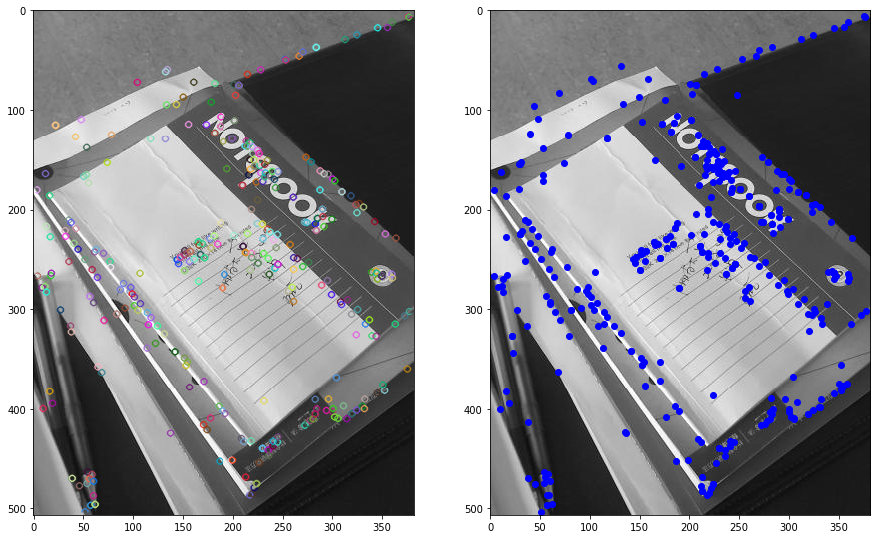

In [3]:
sift = cv2.xfeatures2d.SIFT_create()
(kps, descs) = sift.detectAndCompute(A1, None)
print("opencv method:  features: {}, descriptors: {}        Sift alg: features: {}, descriptors: {}".format(len(kps), descs.shape,len(des1[1]),des1[0].shape))
output_img=np.zeros_like(Original_img)
cv2.drawKeypoints(Original_img,kps,output_img)
plt.subplot(121)
plt.imshow(output_img)
plt.subplot(122)
plot_features(Original_img, des1[1])
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

opencv method:  features: 376, descriptors: (376, 128)        Sift alg: features: 409, descriptors: (409, 128)


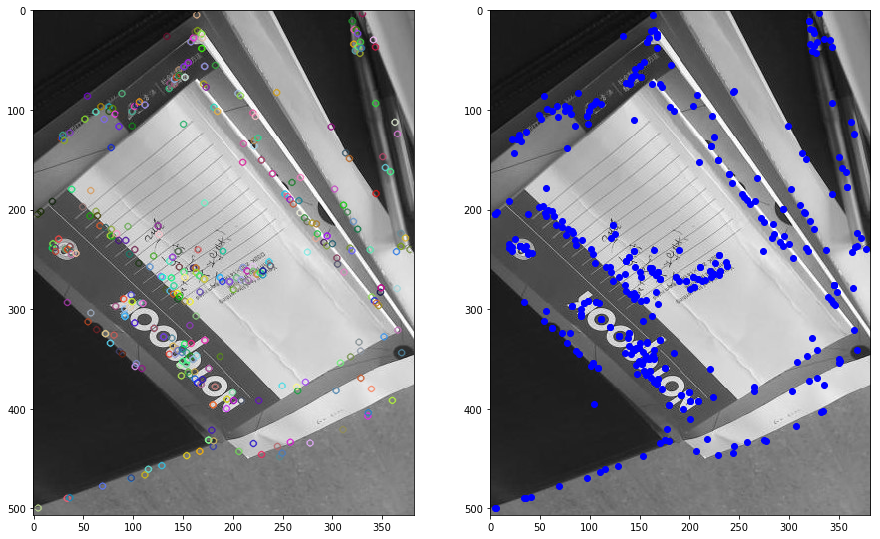

In [14]:
sift = cv2.xfeatures2d.SIFT_create()
(kps, descs) = sift.detectAndCompute(A5, None)
print("opencv method:  features: {}, descriptors: {}        Sift alg: features: {}, descriptors: {}".format(len(kps), descs.shape,len(des5[1]),des5[0].shape))
output_img=np.zeros_like(Original_img4)
cv2.drawKeypoints(Original_img4,kps,output_img)
plt.subplot(121)
plt.imshow(output_img)
plt.subplot(122)
plot_features(Original_img4, des5[1])
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

opencv method:  features: 378, descriptors: (378, 128)        Sift alg: features: 391, descriptors: (391, 128)


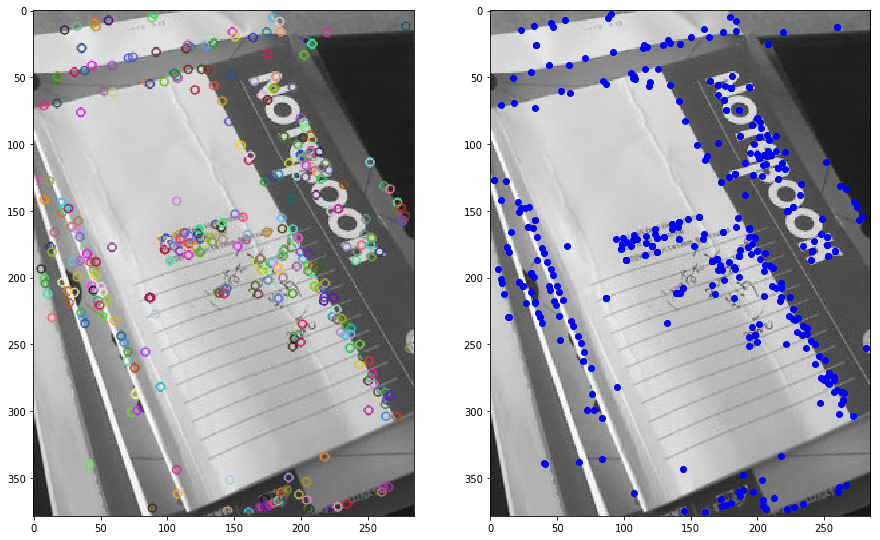

In [16]:
sift = cv2.xfeatures2d.SIFT_create()
(kps, descs) = sift.detectAndCompute(A6, None)
print("opencv method:  features: {}, descriptors: {}        Sift alg: features: {}, descriptors: {}".format(len(kps), descs.shape,len(des6[1]),des6[0].shape))
output_img=np.zeros_like(Original_img5)
cv2.drawKeypoints(Original_img5,kps,output_img)
plt.subplot(121)
plt.imshow(output_img)
plt.subplot(122)
plot_features(Original_img5, des6[1])
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

opencv method:  features: 457, descriptors: (457, 128)        Sift alg: features: 461, descriptors: (461, 128)


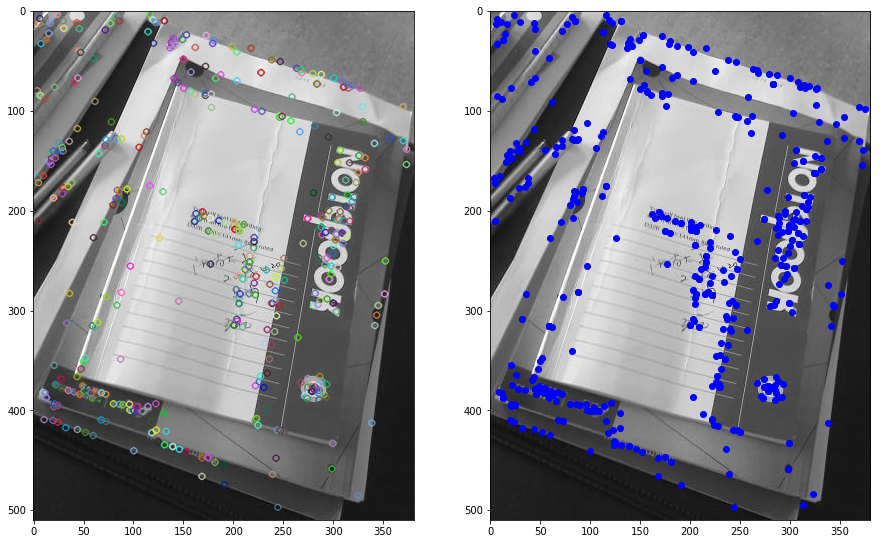

In [4]:
sift = cv2.xfeatures2d.SIFT_create()
(kps, descs) = sift.detectAndCompute(A2, None)
print("opencv method:  features: {}, descriptors: {}        Sift alg: features: {}, descriptors: {}".format(len(kps), descs.shape,len(des2[1]),des2[0].shape))
output_img2=np.zeros_like(Original_img2)
cv2.drawKeypoints(Original_img2,kps,output_img2)
plt.subplot(121)
plt.imshow(output_img2)
plt.subplot(122)
plot_features(Original_img2, des2[1])
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

opencv method:  kps: 109, descriptors: (109, 128)        Sift alg: kps: 117, descriptors: (117, 128)


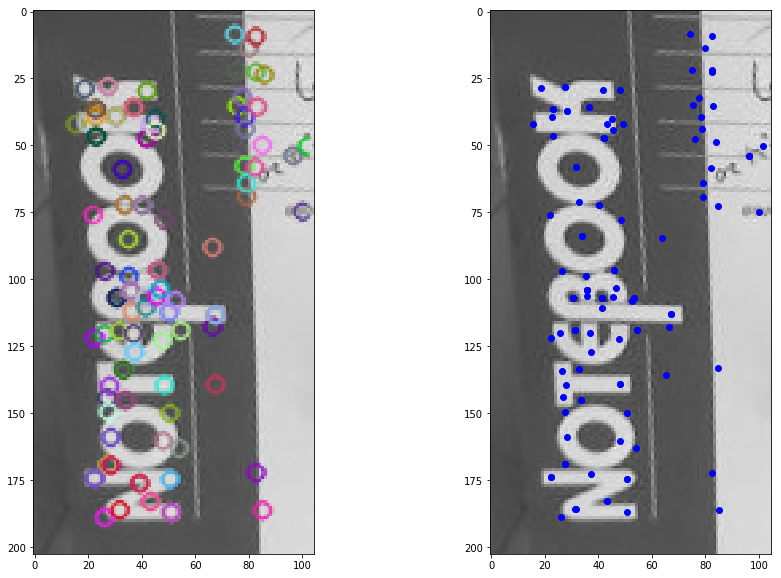

In [5]:
sift = cv2.xfeatures2d.SIFT_create()
(kps, descs) = sift.detectAndCompute(A3, None)
print("opencv method:  kps: {}, descriptors: {}        Sift alg: kps: {}, descriptors: {}".format(len(kps), descs.shape,len(des3[1]),des3[0].shape))
output_img3=np.zeros_like(Original_img3)
cv2.drawKeypoints(Original_img3,kps,output_img3)
plt.subplot(121)
plt.imshow(output_img3)
plt.subplot(122)
plot_features(Original_img3, des3[1])
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

In [4]:
sift = cv2.xfeatures2d.SIFT_create()
(kps, descs) = sift.detectAndCompute(A4, None)
print("opencv method:  features: {}, descriptors: {}        Sift alg: features: {}, descriptors: {}".format(len(kps), descs.shape,len(des4[1]),des4[0].shape))


opencv method:  features: 116, descriptors: (116, 128)        Sift alg: features: 114, descriptors: (114, 128)


The first figure shows the result of one-sided matching, and the second one shows the result of two-sided matching.


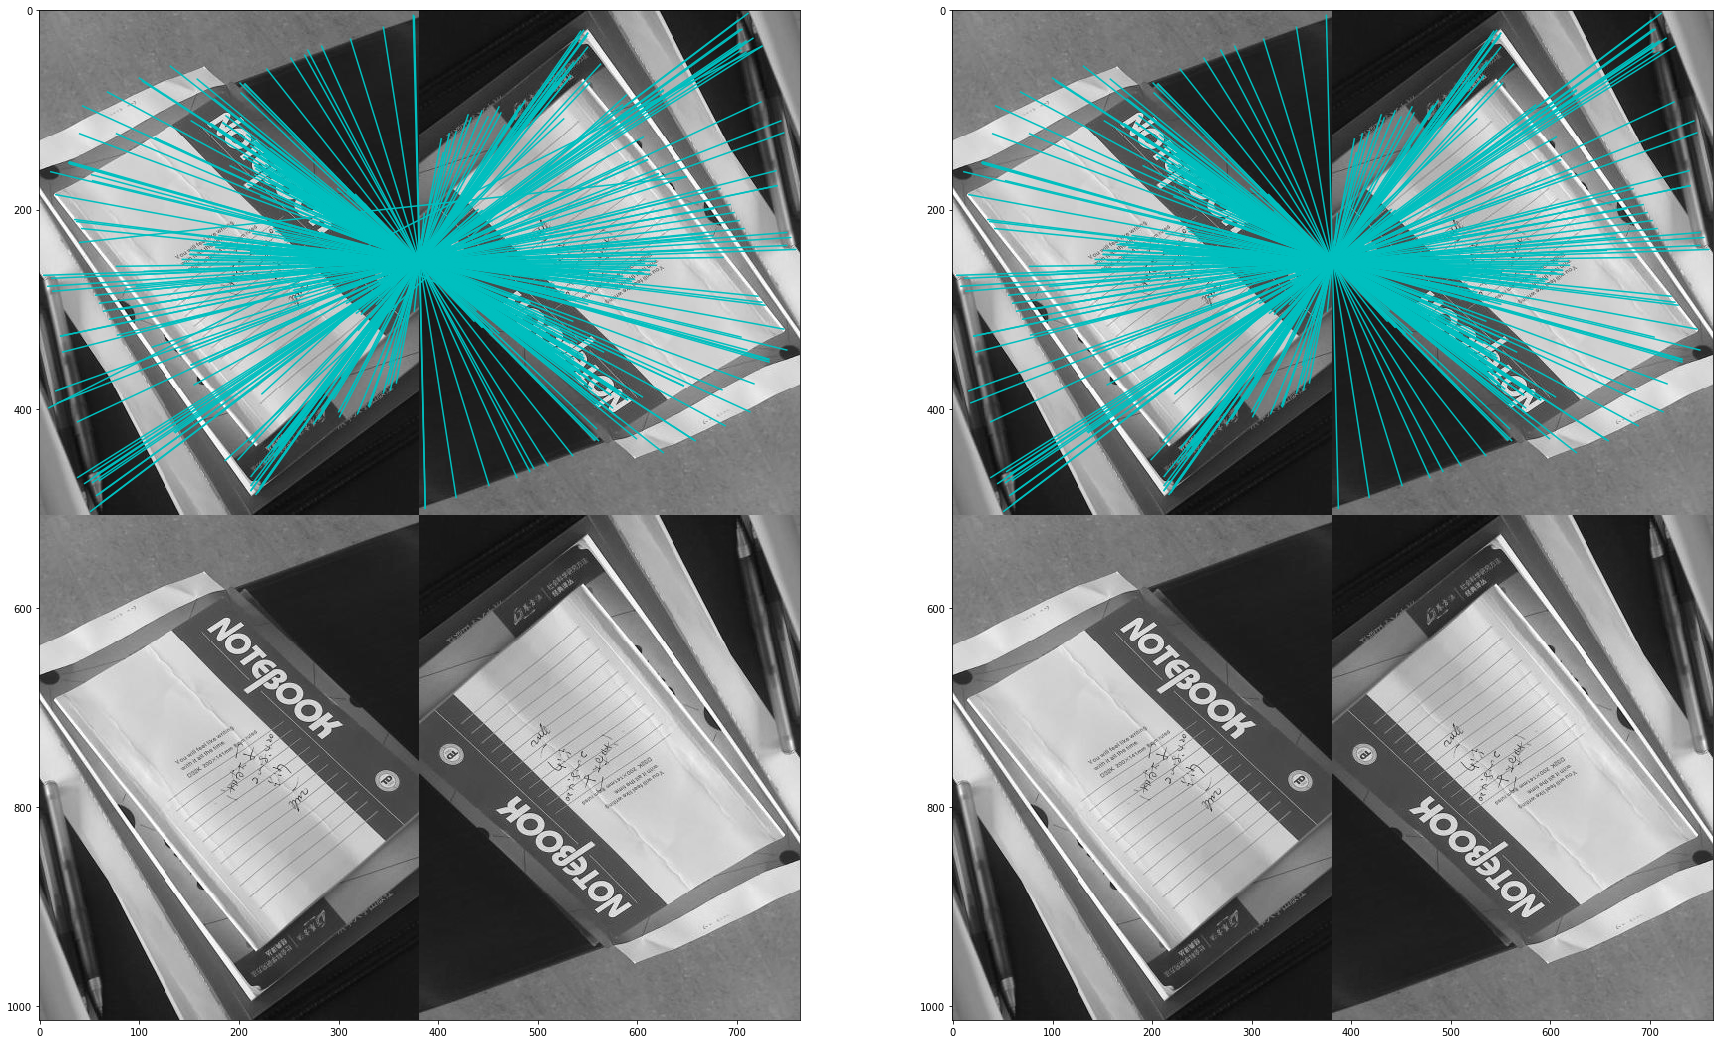

The number of one-sided matching pairs is 286 
The number of two-sided matching pairs is 275 


In [6]:
print('The first figure shows the result of one-sided matching, and the second one shows the result of two-sided matching.')
plt.subplot(121)
matches = match(des1[0], des5[0])
plot_matches(A1,A5,des1[1], des5[1],matches,show_below=True)
plt.subplot(122)
matches1 = match_twosided(des1[0], des5[0])
plot_matches(A1,A5,des1[1], des5[1],matches1,show_below=True)
fig = plt.gcf()
fig.set_size_inches(30, 20)
plt.show()
print("The number of one-sided matching pairs is {} ".format(len(np.where(matches>0)[0])))
print("The number of two-sided matching pairs is {} ".format(len(np.where(matches1>0)[0])))

The first figure shows the result of one-sided matching, and the second one shows the result of two-sided matching.


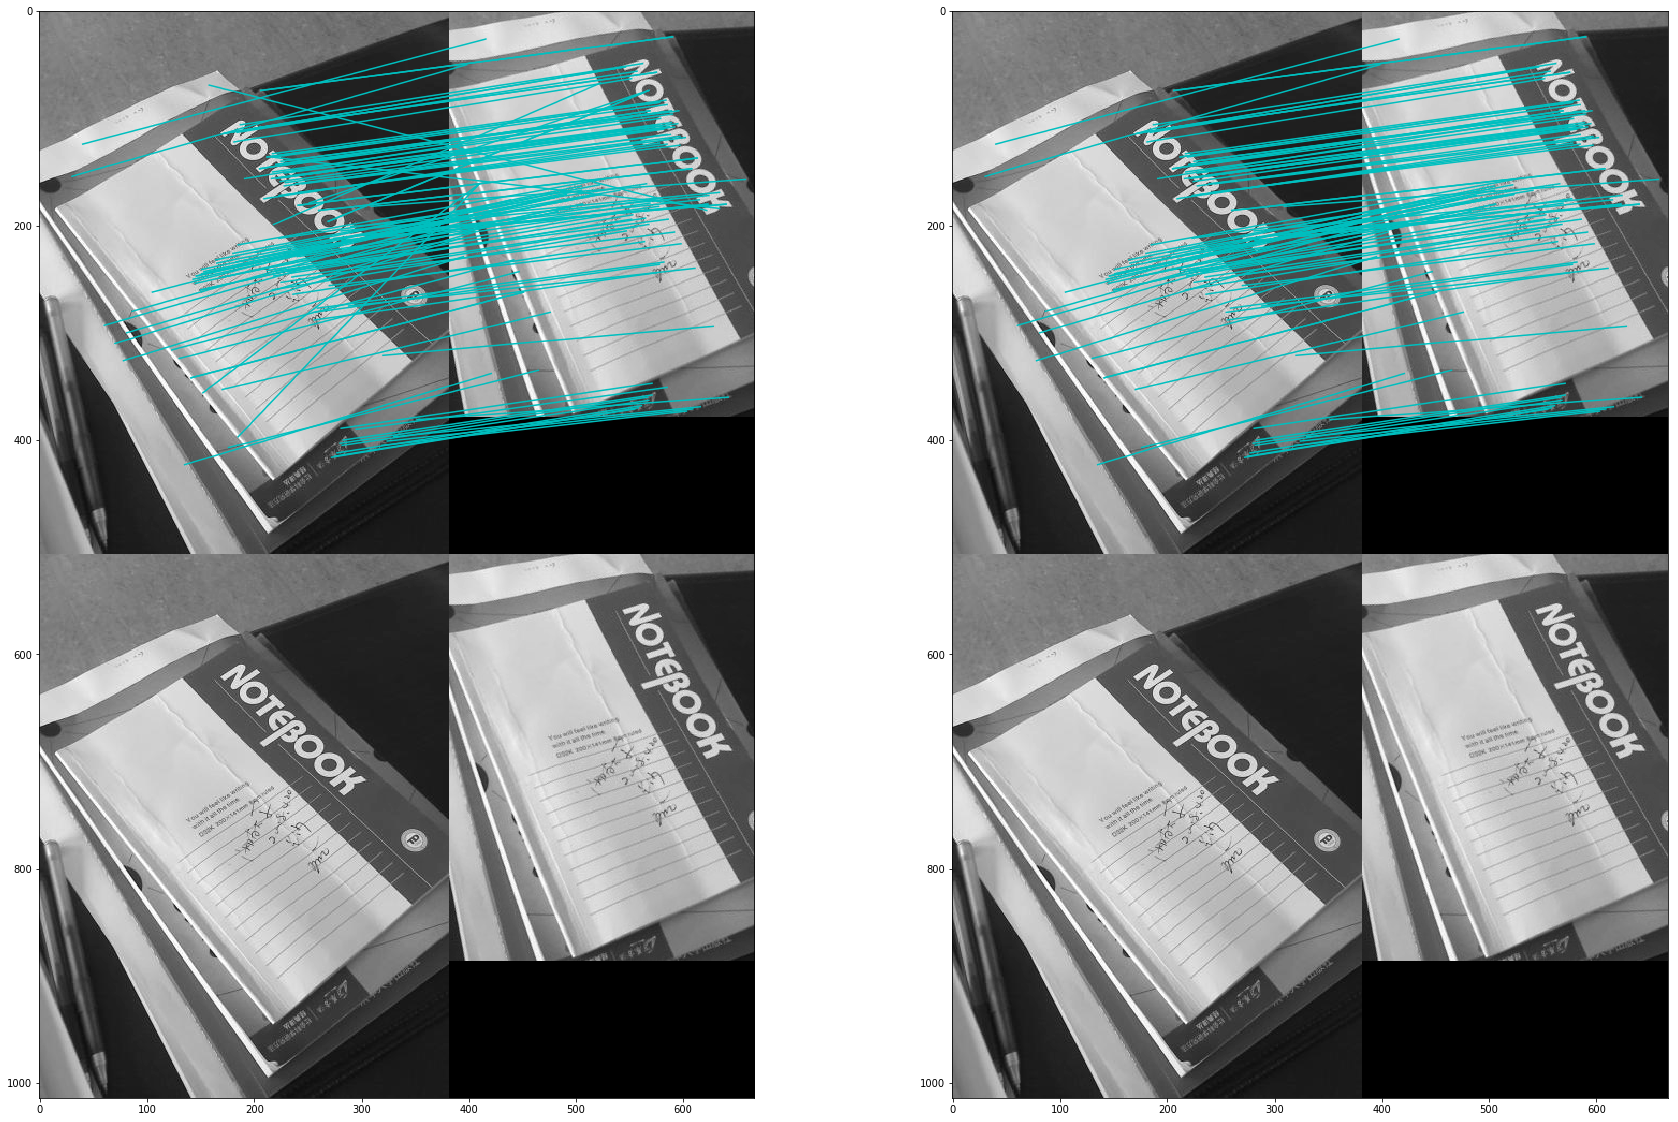

The number of one-sided matching pairs is 124 
The number of two-sided matching pairs is 107 


In [7]:
print('The first figure shows the result of one-sided matching, and the second one shows the result of two-sided matching.')
plt.subplot(121)
matches2 = match(des1[0], des6[0])
plot_matches(A1,A6,des1[1], des6[1],matches2,show_below=True)
plt.subplot(122)
matches3 = match_twosided(des1[0], des6[0])
plot_matches(A1,A6,des1[1], des6[1],matches3,show_below=True)
fig = plt.gcf()
fig.set_size_inches(30, 20)
plt.show()
print("The number of one-sided matching pairs is {} ".format(len(np.where(matches2>0)[0])))
print("The number of two-sided matching pairs is {} ".format(len(np.where(matches3>0)[0])))

The first figure shows the result of one-sided matching, and the second one shows the result of two-sided matching.


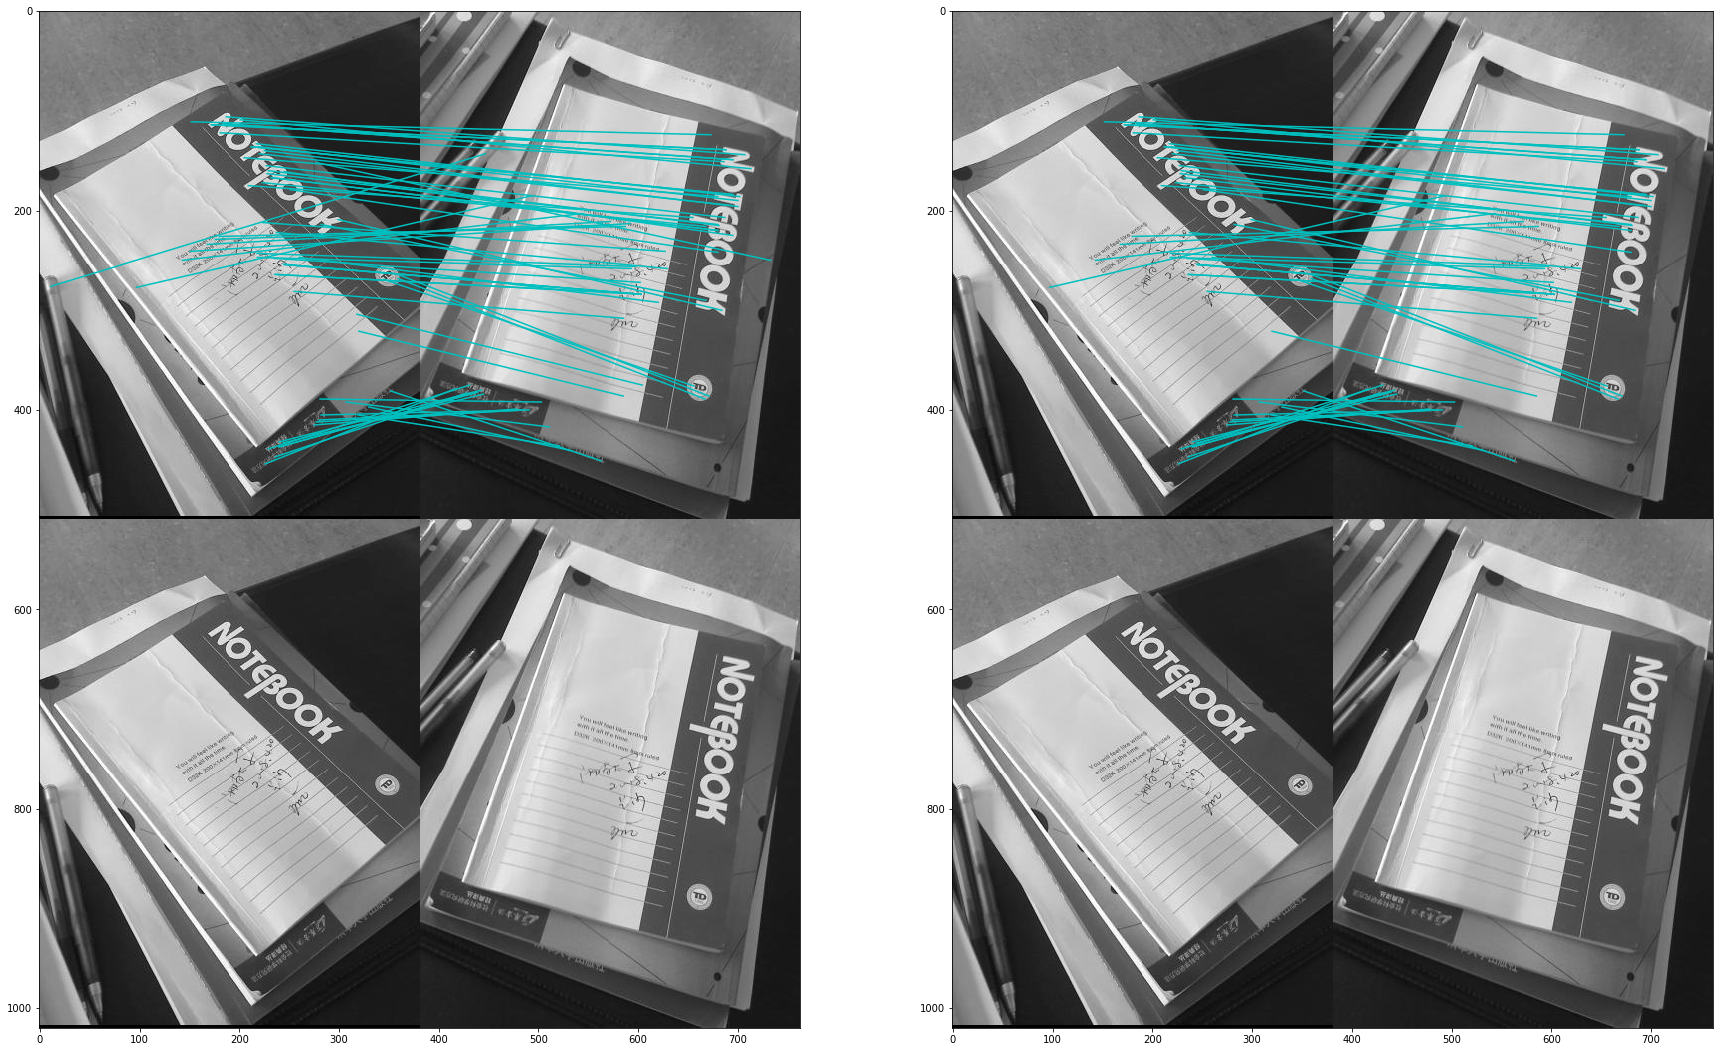

The number of one-sided matching pairs is 67 
The number of two-sided matching pairs is 59 


In [8]:
print('The first figure shows the result of one-sided matching, and the second one shows the result of two-sided matching.')
plt.subplot(121)
matches4 = match(des1[0], des2[0])
plot_matches(A1,A2,des1[1], des2[1],matches4,show_below=True)
plt.subplot(122)
matches5 = match_twosided(des1[0], des2[0])
plot_matches(A1,A2,des1[1], des2[1],matches5,show_below=True)
fig = plt.gcf()
fig.set_size_inches(30, 20)
plt.show()
print("The number of one-sided matching pairs is {} ".format(len(np.where(matches4>0)[0])))
print("The number of two-sided matching pairs is {} ".format(len(np.where(matches5>0)[0])))

The first figure shows the result of one-sided matching, and the second one shows the result of two-sided matching.


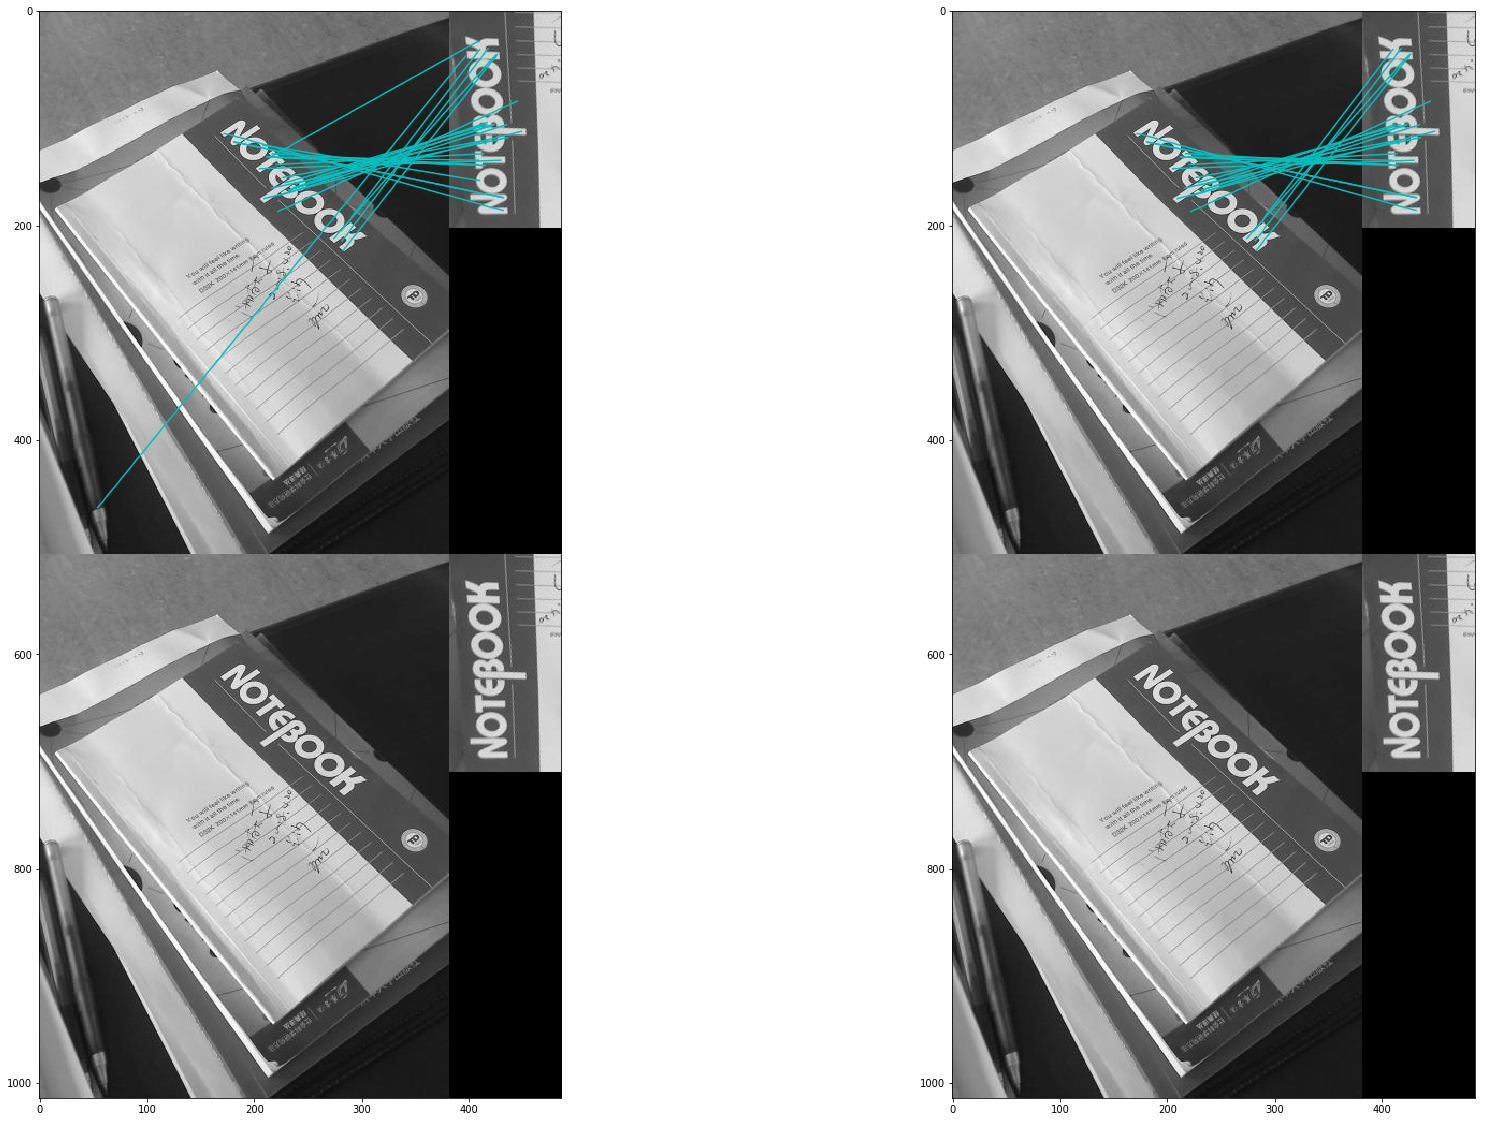

In [9]:
print('The first figure shows the result of one-sided matching, and the second one shows the result of two-sided matching.')
plt.subplot(121)
matches6 = match(des1[0], des3[0])
plot_matches(A1,A3,des1[1], des3[1],matches6,show_below=True)
plt.subplot(122)
matches7 = match_twosided(des1[0], des3[0])
plot_matches(A1,A3,des1[1], des3[1],matches7,show_below=True)
fig = plt.gcf()
fig.set_size_inches(30, 20)
plt.show()

The first figure shows the result of one-sided matching, and the second one shows the result of two-sided matching.


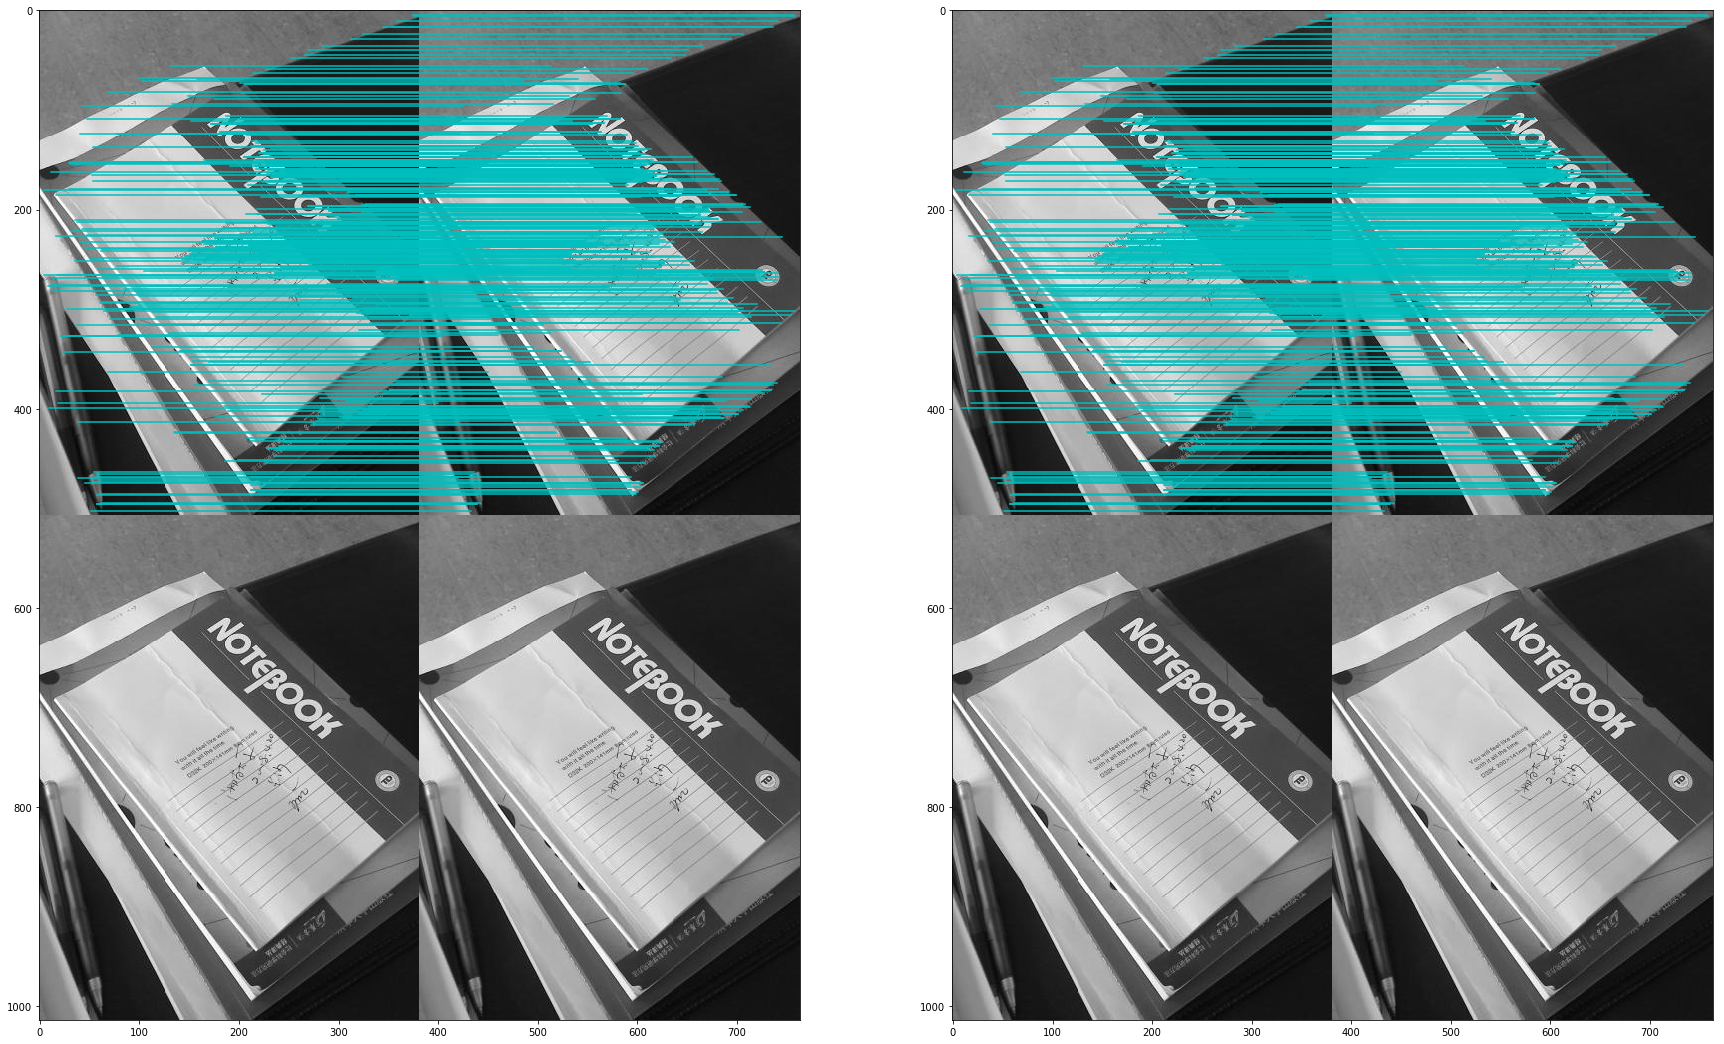

The number of one-sided matching pairs is 389 
The number of two-sided matching pairs is 389 


In [11]:
print('The first figure shows the result of one-sided matching, and the second one shows the result of two-sided matching.')
plt.subplot(121)
matches8 = match(des1[0], des1[0])
plot_matches(A1,A1,des1[1], des1[1],matches8,show_below=True)
plt.subplot(122)
matches9 = match_twosided(des1[0], des1[0])
plot_matches(A1,A1,des1[1], des1[1],matches9,show_below=True)
fig = plt.gcf()
fig.set_size_inches(30, 20)
plt.show()
print("The number of one-sided matching pairs is {} ".format(len(np.where(matches8>0)[0])))
print("The number of two-sided matching pairs is {} ".format(len(np.where(matches9>0)[0])))

The first figure shows the result of one-sided matching, and the second one shows the result of two-sided matching.


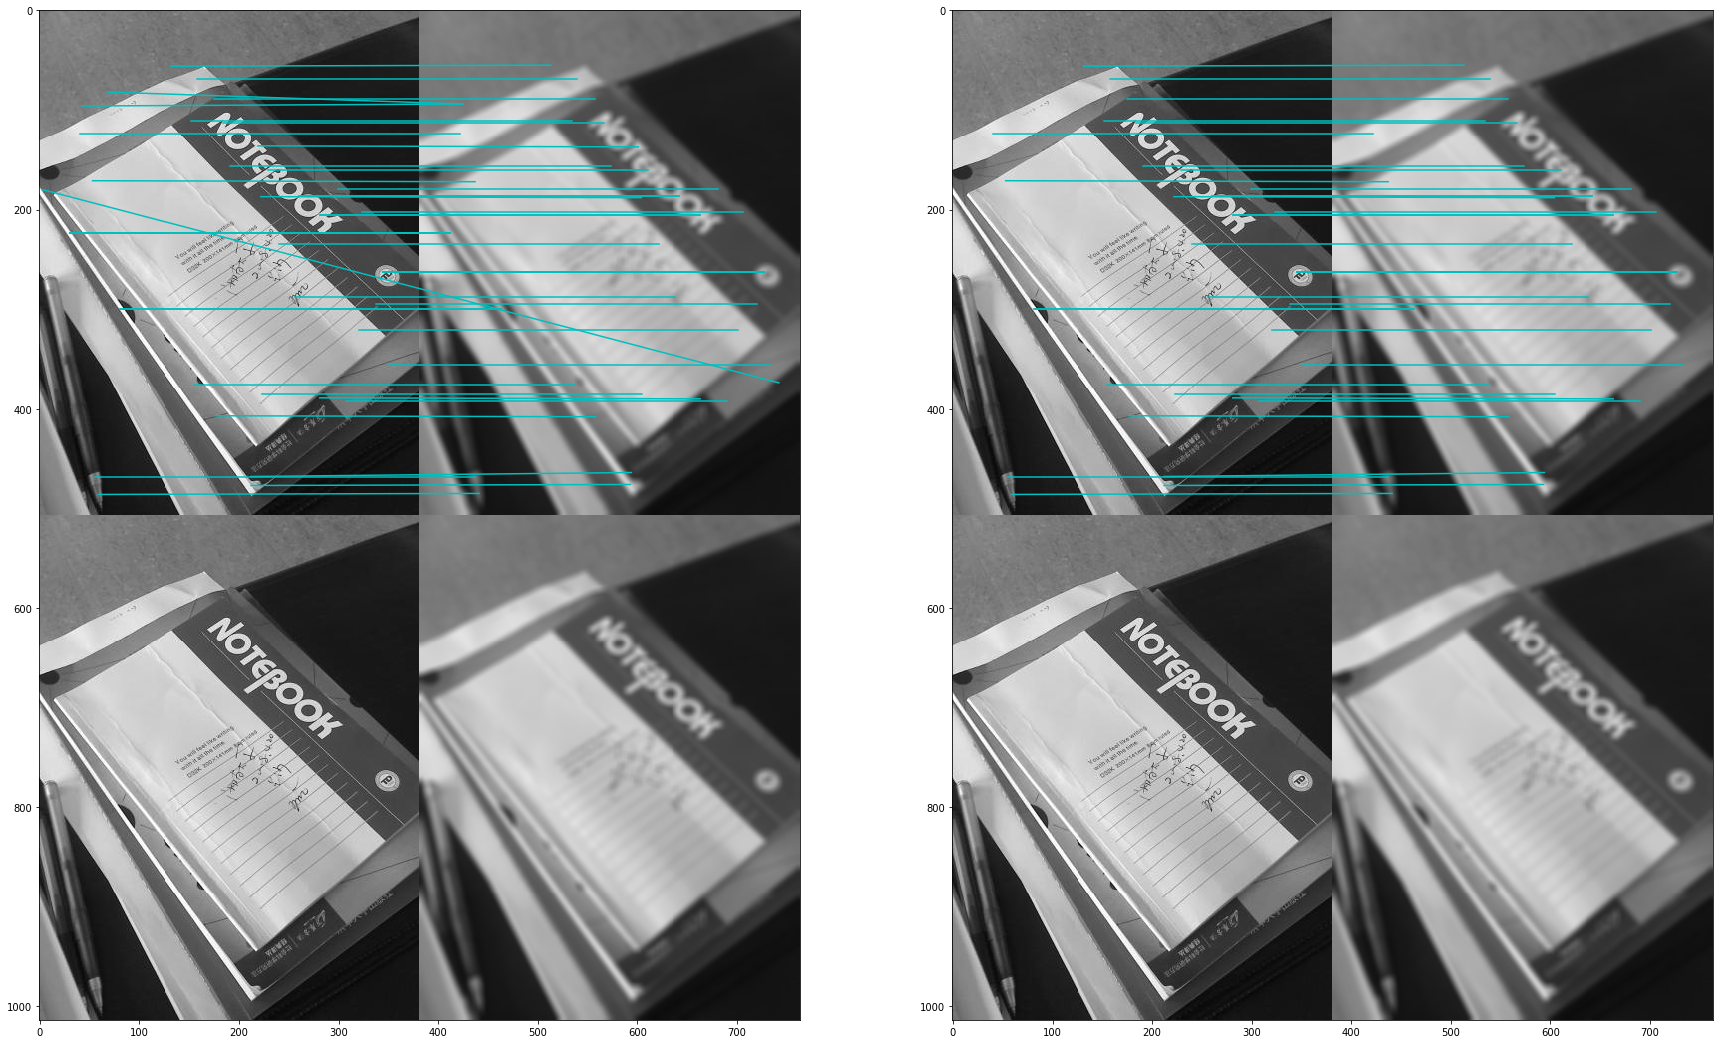

The number of one-sided matching pairs is 48 
The number of two-sided matching pairs is 39 


In [12]:
print('The first figure shows the result of one-sided matching, and the second one shows the result of two-sided matching.')
plt.subplot(121)
matches10 = match(des1[0], des4[0])
plot_matches(A1,A4,des1[1], des4[1],matches10,show_below=True)
plt.subplot(122)
matches11 = match_twosided(des1[0], des4[0])
plot_matches(A1,A4,des1[1], des4[1],matches11,show_below=True)
fig = plt.gcf()
fig.set_size_inches(30, 20)
plt.show()
print("The number of one-sided matching pairs is {} ".format(len(np.where(matches10>0)[0])))
print("The number of two-sided matching pairs is {} ".format(len(np.where(matches11>0)[0])))